In [1]:
!mkdir /content/Garbage_class

In [2]:
cd Garbage_class/

/content/Garbage_class


In [3]:
# Upload the files
from google.colab import files

uploaded = files.upload()

Saving Garbage_classification.zip to Garbage_classification.zip
Saving label_num_to_garbage_map.json to label_num_to_garbage_map.json
Saving test.csv to test.csv
Saving train.csv to train.csv


In [4]:
!unzip Garbage_classification.zip -d ./

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: ./Garbage_classification/test/plastic457.jpg  
  inflating: ./__MACOSX/Garbage_classification/test/._plastic457.jpg  
  inflating: ./Garbage_classification/test/plastic443.jpg  
  inflating: ./__MACOSX/Garbage_classification/test/._plastic443.jpg  
  inflating: ./Garbage_classification/test/paper586.jpg  
  inflating: ./__MACOSX/Garbage_classification/test/._paper586.jpg  
  inflating: ./Garbage_classification/test/paper592.jpg  
  inflating: ./__MACOSX/Garbage_classification/test/._paper592.jpg  
  inflating: ./Garbage_classification/test/glass500.jpg  
  inflating: ./__MACOSX/Garbage_classification/test/._glass500.jpg  
  inflating: ./Garbage_classification/test/paper551.jpg  
  inflating: ./__MACOSX/Garbage_classification/test/._paper551.jpg  
  inflating: ./Garbage_classification/test/paper579.jpg  
  inflating: ./__MACOSX/Garbage_classification/test/._paper579.jpg  
  inflating: ./Garbage_classification/test/glass474.jpg  
  inflating: 

In [5]:
!mv ./Garbage_classification/train ./train
!mv ./Garbage_classification/test ./test
!rm -r ./__MACOSX

In [6]:
import os
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [7]:
# SET PATHS
DATA_DIR = "/content/Garbage_class"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TRAIN_CSV_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_DIR = os.path.join(DATA_DIR, "test")
TEST_CSV_PATH = os.path.join(DATA_DIR, "test.csv")
LABEL_MAP_PATH = os.path.join(DATA_DIR, "label_num_to_garbage_map.json")

# Load CSV and label map
df = pd.read_csv(TRAIN_CSV_PATH)
with open(LABEL_MAP_PATH, 'r') as f:
    label_map = json.load(f)

print("Label Mapping:", label_map)

# Split train/val
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

Label Mapping: {'0': 'glass', '1': 'paper', '2': 'cardboard', '3': 'plastic', '4': 'metal', '5': 'trash'}


In [8]:
# Transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom Dataset
class GarbageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df.iloc[idx]["image_id"]
        label = self.df.iloc[idx]["label"]
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, int(label)

# Create datasets and dataloaders
train_dataset = GarbageDataset(train_df, TRAIN_DIR, transform=train_transform)
val_dataset = GarbageDataset(val_df, TRAIN_DIR, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 1861
Validation samples: 466


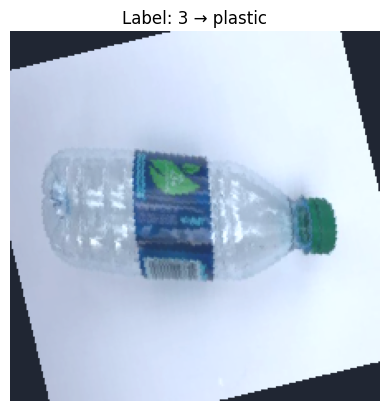

In [9]:
# Show one sample
sample_img, sample_label = train_dataset[0]
plt.imshow(sample_img.permute(1, 2, 0).numpy() * 0.229 + 0.485)
plt.title(f"Label: {sample_label} → {label_map[str(sample_label)]}")
plt.axis('off')
plt.show()

In [17]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import EfficientNet_B0_Weights

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained EfficientNet B0
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = models.efficientnet_b0(weights=weights)

# Replace the final fully connected layer
num_classes = len(label_map)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

Using device: cuda


In [18]:
weights = torch.tensor([1.0, 1.0, 1.0, 3.0, 1.0, 0.5]).to(device)  # Boost plastic, downweight trash
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)

In [19]:
EPOCHS = 10
best_acc = 0.0
best_path = "garbage_classifier_best.pth"

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f"✔ Saved new best model: {best_acc:.2f}%")

Epoch 1/10, Train Loss: 44.5186, Train Acc: 68.89%
Val Loss: 6.8066, Val Acc: 82.62%
✔ Saved new best model: 82.62%
Epoch 2/10, Train Loss: 20.1437, Train Acc: 85.76%
Val Loss: 6.2850, Val Acc: 83.48%
✔ Saved new best model: 83.48%
Epoch 3/10, Train Loss: 15.0380, Train Acc: 88.02%
Val Loss: 4.5079, Val Acc: 87.77%
✔ Saved new best model: 87.77%
Epoch 4/10, Train Loss: 10.9744, Train Acc: 90.81%
Val Loss: 3.8312, Val Acc: 89.70%
✔ Saved new best model: 89.70%
Epoch 5/10, Train Loss: 9.0979, Train Acc: 92.80%
Val Loss: 3.7392, Val Acc: 89.48%
Epoch 6/10, Train Loss: 7.8497, Train Acc: 94.09%
Val Loss: 3.3689, Val Acc: 91.42%
✔ Saved new best model: 91.42%
Epoch 7/10, Train Loss: 5.7563, Train Acc: 96.18%
Val Loss: 3.3728, Val Acc: 91.85%
✔ Saved new best model: 91.85%
Epoch 8/10, Train Loss: 7.0951, Train Acc: 96.29%
Val Loss: 3.4159, Val Acc: 90.99%
Epoch 9/10, Train Loss: 4.3376, Train Acc: 97.47%
Val Loss: 2.9328, Val Acc: 92.49%
✔ Saved new best model: 92.49%
Epoch 10/10, Train Loss

In [20]:
test_df = pd.read_csv(TEST_CSV_PATH)

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = GarbageDataset(test_df, TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 76.50%


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

# Store true & predicted labels
all_preds = []
all_labels = []
all_image_ids = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# If you have image_ids in test_df
all_image_ids = test_df["image_id"].tolist()

# Classification report
target_names = [label_map[str(i)] for i in range(num_classes)]
print(classification_report(all_labels, all_preds, target_names=target_names))

# Create DataFrame for analysis
results_df = pd.DataFrame({
    "image_id": all_image_ids,
    "true_label": all_labels,
    "predicted_label": all_preds
})

# Save to CSV
results_df.to_csv("test_prediction.csv", index=False)

              precision    recall  f1-score   support

       glass       0.80      0.90      0.85        40
       paper       0.78      0.87      0.82        45
   cardboard       0.92      0.97      0.94        35
     plastic       0.79      0.28      0.41        40
       metal       0.76      0.97      0.85        30
       trash       0.25      0.40      0.31        10

    accuracy                           0.77       200
   macro avg       0.72      0.73      0.70       200
weighted avg       0.78      0.77      0.74       200

